# Normal Normal Log-Normal and Multivariate T, Multivariate Gamma, Inverse Gamma Simulations: MSE & Coverage

This notebook goes over the code needed to reproduce the results from the MSE and time figures in the first two simulations in the paper: the Normal Normal Log-Normal simulation and the Multivariate T, Multivariate Gamma, Inverse-Gamma simulation. 

The provided code produces results given in Figures 2 and 3, in addition to Supplementary Tables S.1 and S.2.

The simulations were run in Julia version 1.4.0. The `randn!()` function changed in v1.5.0, and will produce different random numbers for the simulation. 

### Packages and Reproducibility

Julia allows for easy reproducibility, by including a `Manifest.toml` and `Project.toml` pair, the user can simply run `] activate .` and the correct environment with dependencies used will run.  

In [94]:
]activate .

 Activating environment at `~/WiSER_Reproduce/simulations/Project.toml`


Note: We use the KNITRO solver in our analysis, which requires a KNITRO license. If you wish to run the analysis without it, you can use another solver, but the results will be slightly different. To do this, comment out the code each time it says `solver = KNITRO...` and replace it with `solver = Ipopt.IpoptSolver(print_level=0, watchdog_shortened_iter_trigger=3, max_iter=100)`.

In [2]:
versioninfo()

Julia Version 1.4.0
Commit b8e9a9ecc6 (2020-03-21 16:36 UTC)
Platform Info:
  OS: Linux (x86_64-pc-linux-gnu)
  CPU: Intel(R) Core(TM) i9-9920X CPU @ 3.50GHz
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-8.0.1 (ORCJIT, skylake)
Environment:
  JULIA_NUM_THREADS = 8


**Note**: The simulation blocks take a long time to run on a standard PC. We have provided the output files, so please feel free to skip the simulation blocks.

## Normal-Normal Log-Normal Simulation

The following code runs the simulation and saves the results.

In [ ]:
using WiSER, DelimitedFiles, LinearAlgebra, Random, KNITRO
using Random, Roots, SpecialFunctions

function MSE(m::WSVarLmmModel, β::Vector, τ::Vector, Σγ::Matrix)
    mseβ = sum(abs2, m.β - β) / m.p
    mseτ = sum(abs2, m.τ[2:end] - τ[2:end]) / (m.l - 1)
    msevechLγ = sum(abs2, m.Σγ - Σγ) / abs2(m.q)
    return mseβ, mseτ, msevechLγ
end

function coverage!(m::WSVarLmmModel, trueparams::Vector, 
    intervals::Matrix, curcoverage::Vector)

    copyto!(intervals, confint(m))
    lbs = @views intervals[:, 1]
    ubs = @views intervals[:, 2]
    map!((val, lb, ub) -> val >= lb && 
        val <= ub, curcoverage, trueparams, lbs, ubs)
    return curcoverage
end

# dimensions
@show Threads.nthreads()
p  = 5    # number of fixed effects, including intercept
q  = 3    # number of random effects, including intercept
l  = 5    # number of WS variance covariates, including intercept
# true parameter values
βtrue = [ 0.1; 6.5; -3.5; 1.0; 5  ]
τtrue = [0.0; 0.5; -0.2; 0.5; 0.0]
Σγ    = [1.5 0.5 0.3;
         0.5 1.0 0.2;
         0.3 0.2 0.5];
δγω   = [0.2; 0.1; 0.05]
σω    = [0.5]
Σγω   = [Σγ δγω; δγω' σω]
Lγω   = cholesky(Symmetric(Σγω), check = false).L
Lγ    = Lγω[1:q, 1:q]
lγω   = Lγω[q + 1, 1:q]
lω    = Lγω[q + 1, q + 1]
# generate data
γω = Vector{Float64}(undef, q + 1)
z  = similar(γω) # hold vector of iid std normal

intervals = zeros(p + l, 2) #hold intervals
curcoverage = zeros(p + l) #hold current coverage resutls
trueparams = [βtrue; τtrue] #hold true parameters

#simulation parameters
samplesizes = collect(1000:1000:6000)
ns = [10; 25; 50; 100; 1000]
nsims = 1000

#storage for results
βMseResults = ones(nsims * length(ns) * length(samplesizes))
τMseResults = ones(nsims * length(ns) * length(samplesizes))
ΣγMseResults = ones(nsims * length(ns) *  length(samplesizes))
βτcoverage = Matrix{Float64}(undef, p + l, nsims * length(ns) * length(samplesizes))
fittimes = zeros(nsims * length(ns) * length(samplesizes))
solver = KNITRO.KnitroSolver(outlev=0)

st = time()
currentind = 1
for t in 1:length(samplesizes)
    m = samplesizes[t]
    obsvec = Vector{WSVarLmmObs{Float64}}(undef, m)
    for k in 1:length(ns)
        ni = ns[k] # number of observations per individual
        y = Vector{Float64}(undef, ni)
        for j in 1:nsims
            println("rep $j obs per person $ni samplesize $m")
            Random.seed!(j + 100000k + 1000t)
            for i in 1:m
                # first column intercept, remaining entries iid std normal
                X = Matrix{Float64}(undef, ni, p)
                X[:, 1] .= 1
                @views randn!(X[:, 2:p])
                # first column intercept, remaining entries iid std normal
                Z = Matrix{Float64}(undef, ni, q)
                Z[:, 1] .= 1
                @views randn!(Z[:, 2:q])
                # first column intercept, remaining entries iid std normal
                W = Matrix{Float64}(undef, ni, l)
                W[:, 1] .= 1
                @views randn!(W[:, 2:l])
                # generate random effects: γω = Lγω * z
                mul!(γω, Lγω, randn!(z))
                # generate y
                μy = X * βtrue + Z * γω[1:q]
                @views ysd = exp.(0.5 .* (W * τtrue .+ dot(γω[1:q], lγω) .+ γω[end]))
                y = ysd .* randn(ni) .+ μy
                # form a VarLmmObs instance
                obsvec[i] = WSVarLmmObs(y, X, Z, W)
            end
            # form VarLmmModel
            vlmm = WSVarLmmModel(obsvec);
            fittime = NaN
            try 
                fittime = @elapsed WiSER.fit!(vlmm, solver, parallel=false)
                confint(vlmm)
            catch
                println("rep $j ni obs = $ni , samplesize = $m had an error")
                try 
                    fittime = @elapsed WiSER.fit!(vlmm, Ipopt.IpoptSolver(print_level=1, 
                        watchdog_shortened_iter_trigger=3, max_iter=100), parallel=false)
                        confint(vlmm)
                catch
                    println("rep $j ni obs = $ni , samplesize = $m had a second error")
                    try
                        fittime = @elapsed WiSER.fit!(vlmm, init = init_mom!(vlmm), parallel=false)
                        confint(vlmm)
                    catch
                        println("rep $j ni obs = $ni , samplesize = $m had a third error")
                        βMseResults[currentind] = NaN
                        τMseResults[currentind] = NaN
                        ΣγMseResults[currentind] = NaN
                        βτcoverage[:, currentind] .= NaN
                        fittimes[currentind] = NaN
                        currentind += 1
                        continue
                    end
                end
            end
            coverage!(vlmm, trueparams, intervals, curcoverage)
            mseβ, mseτ, mseΣγ = MSE(vlmm, βtrue, τtrue, Σγ)

            #index = Int(nsims * length(ns) * (t - 1) + nsims * (k - 1) + j)
            global currentind
            @views copyto!(βτcoverage[:, currentind], curcoverage)
            βMseResults[currentind] = mseβ
            τMseResults[currentind] = mseτ
            ΣγMseResults[currentind] = mseΣγ
            fittimes[currentind] = fittime
            currentind += 1
        end
    end
end 
en = time()

@show en - st #seconds 

ftail = "normal_normal_lognormal_$(nsims)reps_sim.csv"
writedlm("result_files/mse_beta_" * ftail, βMseResults, ',')
writedlm("result_files/mse_tau_" * ftail, τMseResults, ',')
writedlm("result_files/mse_Sigma_" * ftail, ΣγMseResults, ',')
writedlm("result_files/beta_tau_coverage_5betas_" * ftail, βτcoverage, ',')
writedlm("result_files/fittimes" * ftail, fittimes, ',')

### Timing figure (Figure 2)

The following code will create the Time figure (Figure 2).

In [3]:
using Random, DataFrames, DelimitedFiles, Statistics, RCall, Printf
import StatsBase: sem
ENV["COLUMNS"]=1000

βMseresult = vec(readdlm("result_files/mse_beta_normal_normal_lognormal_1000reps_sim.csv", ','))
τMseresult = vec(readdlm("result_files/mse_tau_normal_normal_lognormal_1000reps_sim.csv", ','))
ΣMseresult = vec(readdlm("result_files/mse_Sigma_normal_normal_lognormal_1000reps_sim.csv", ','))
fittimes = vec(readdlm("result_files/fittimesnormal_normal_lognormal_1000reps_sim.csv", ','))

samplesizes = collect(1000:1000:6000)
ns = [10; 25; 50; 100; 1000]
nsims = 1000

p = 5; l = 5
sample_sizes = repeat(string.(samplesizes), inner = nsims * length(ns))
obs_sizes = repeat(string.(ns), inner = nsims, outer = length(samplesizes))
msedf = DataFrame(βmse = βMseresult, τmse = τMseresult, Σγmse = ΣMseresult, 
    samplesize = sample_sizes, obssize = obs_sizes, fittimes = fittimes)
timedf = combine(groupby(msedf, [:samplesize, :obssize]), :fittimes => mean => :fittime,
    :fittimes => x -> (std(x)/sqrt(length(x))))
rename!(timedf, Dict(:fittimes_function => "se"))
timedf[!, :nobs] = Meta.parse.(timedf[!, :samplesize]) .* Meta.parse.(timedf[!, :obssize])
timedf[!, :fitmin] = timedf[!, :fittime] - timedf[!, :se]
timedf[!, :fitmax] = timedf[!, :fittime] + timedf[!, :se]
timedf[!, :perobsratio] = timedf[!, :fittime] ./ timedf[!, :nobs]
timedf

,samplesize,obssize,fittime,se,nobs,fitmin,fitmax,perobsratio
,String,String,Float64,Float64,Int64,Float64,Float64,Float64
1,1000,10,1.04326,0.0143101,10000,1.02895,1.05758,0.000104326
2,1000,25,1.235,0.0159857,25000,1.21901,1.25098,4.93999e-5
3,1000,50,1.49699,0.0194673,50000,1.47753,1.51646,2.99399e-5
4,1000,100,2.17399,0.0290041,100000,2.14498,2.20299,2.17399e-5
5,1000,1000,11.6524,0.135742,1000000,11.5167,11.7881,1.16524e-5
6,2000,10,1.5317,0.028151,20000,1.50355,1.55985,7.65851e-5
7,2000,25,1.69683,0.0329478,50000,1.66388,1.72978,3.39366e-5
8,2000,50,2.20178,0.0442731,100000,2.15751,2.24606,2.20178e-5
9,2000,100,3.18849,0.0505378,200000,3.13795,3.23903,1.59424e-5


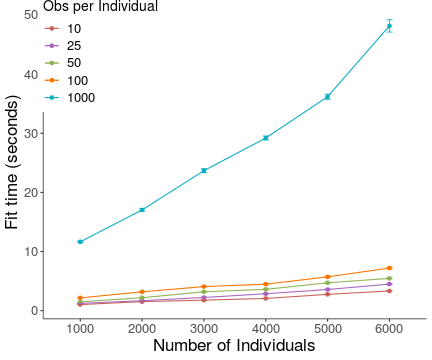

RObject{VecSxp}


In [4]:
using RCall
@rput timedf

R"""
library(ggplot2)
timedf$obssize <- factor(timedf$obssize, levels = c('10', '25', '50', '100', '1000'))
timedf$samplesize <- factor(timedf$samplesize, levels = c('1000', '2000', '3000', '4000', '5000', '6000'))

fittime_1 = ggplot(timedf, aes(x=samplesize, y=fittime, group=obssize, color=obssize)) + 
  geom_line() +
  geom_point()+
  geom_errorbar(aes(ymin=fitmin, ymax=fitmax), width=0.5, alpha = 0.8, position=position_dodge(0.005)) + 
  theme(legend.position=c(0.15,0.85), legend.key = element_blank(), axis.text.x = element_text(angle=0, size=13),
        axis.text.y = element_text(angle=0, size=13), axis.title.x = element_text(size = 17), 
        axis.title.y = element_text(size = 17), legend.title = element_text(size = 14),
        #axis.ticks = element_blank(),
        panel.grid.major = element_blank(), legend.text=element_text(size=13),
        panel.border = element_blank(), panel.grid.minor = element_blank(), panel.background = element_blank(), 
        axis.line = element_line(color = 'black',size=0.3), plot.title = element_text(hjust = 0.5)) + 
   scale_color_manual(values = c("#c85f55",
"#a964bf",
"#8db352",
"#fa7300",
"#05aec0")) +
  labs(x = "Number of Individuals", y = "Fit time (seconds)", color = "Obs per Individual")


"""

In [6]:
#R"""
#ggsave('result_files/updated_singlethread_fittimes.png', fittime_1, width = 8, height = 8, units = 'in', dpi = 450)
#"""

RObject{NilSxp}
NULL


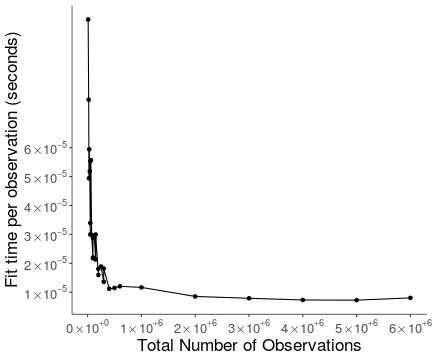

RObject{VecSxp}


In [5]:
using RCall
@rput timedf

R"""
library(scales)
library(ggplot2)
timedf$obssize <- factor(timedf$obssize, levels = c('10', '25', '50', '100', '1000'))
timedf$samplesize <- factor(timedf$samplesize, levels = c('1000', '2000', '3000', '4000', '5000', '6000'))

fancy_scientific <- function(l) {
     # turn in to character string in scientific notation
     l <- format(l, scientific = TRUE)
     # quote the part before the exponent to keep all the digits
     l <- gsub("^(.*)e", "'\\1'e", l)
     # turn the 'e+' into plotmath format
     l <- gsub("e", "%*%10^", l)
     # return this as an expression
     parse(text=l)
}

fittimeperobs = ggplot(timedf, aes(x=nobs, y=perobsratio)) + 
  geom_line() +
  geom_point()+
#  geom_errorbar(aes(ymin=fitmin, ymax=fitmax), width=0.5, alpha = 0.8, position=position_dodge(0.005)) + 
  theme(legend.position=c(0.15,0.8), legend.key = element_blank(), axis.text.x = element_text(angle=0, size=13),
        axis.text.y = element_text(angle=0, size=13), axis.title.x = element_text(size = 17), 
        axis.title.y = element_text(size = 17), legend.title = element_text(size = 14),
        #axis.ticks = element_blank(),
        panel.grid.major = element_blank(), legend.text=element_text(size=11),
        panel.border = element_blank(), panel.grid.minor = element_blank(), panel.background = element_blank(), 
        axis.line = element_line(color = 'black',size=0.3), plot.title = element_text(hjust = 0.5)) + 
  labs(x = "Total Number of Observations", y = "Fit time per observation (seconds)", color = "Obs per Individual") +
#scale_x_log10(breaks = 10^seq(0, 7, 1), labels=trans_format("log10", math_format(10^.x)))# + #, limit=c(10^0, 10^7))
scale_x_continuous(breaks = seq(0, 6000000, 1000000), labels= fancy_scientific) +
scale_y_continuous(breaks = c(10^-5, 2 * 10^-5, 3 * 10^-5, 4 * 10^-5, 5 * 10^-5, 6 * 10^-5), labels= fancy_scientific)

"""

In [7]:
#R"""
#ggsave('result_files/updated_singlethread_fittimeperobs.png', fittimeperobs, width = 8, height = 8, units = 'in', dpi = 450)
#"""

RObject{NilSxp}
NULL


### Supplementary Table S.1

The following code produces results seen in the Supplementary Table S.1.

In [88]:
using Random, DataFrames, DelimitedFiles, Statistics
import StatsBase: sem
ENV["COLUMNS"]=800

βτcoverage = readdlm("result_files/beta_tau_coverage_5betas_normal_normal_lognormal_1000reps_sim.csv", ',')
samplesizes = collect(1000:1000:6000)
ns = [10; 25; 50; 100; 1000]
nsims = 1000

covdf = DataFrame(transpose(βτcoverage))
rename!(covdf, Symbol.([["β$i" for i in 1:p]; ["τ$i" for i in 1:l]]))
covdf[!, :samplesize] = sample_sizes
covdf[!, :obssize] = obs_sizes
first(covdf, 10)

row_stats = [[(mean(col), sem(col)) for col = eachcol(d[!, 1:end-2])] for d = groupby(covdf, [:samplesize; :obssize])]
df = DataFrame(row_stats)
ss_obs = unique("m: " .* sample_sizes .* "  ni: " .* obs_sizes)
rename!(df, Symbol.(ss_obs))
covdfdisplay = DataFrame([[names(df)]; collect.(eachrow(df))], 
    [:people_obs; Symbol.([["β$i" for i in 1:p]; ["τ$i" for i in 1:l]])])
deletecols!(covdfdisplay, p + 2)
covdfdisplay

┌ Warning: `deletecols!(df::DataFrame, inds)` is deprecated, use `select!(df, Not(inds))` instead.
│   caller = top-level scope at In[88]:22
└ @ Core In[88]:22


,people_obs,β1,β2,β3,β4,β5,τ2,τ3,τ4,τ5
,String,Tuple…,Tuple…,Tuple…,Tuple…,Tuple…,Tuple…,Tuple…,Tuple…,Tuple…
1,m: 1000 ni: 10,"(0.952, 0.00676326)","(0.943, 0.00733518)","(0.951, 0.00682976)","(0.951, 0.00682976)","(0.944, 0.0072744)","(0.939, 0.00757208)","(0.943, 0.00733518)","(0.947, 0.00708811)","(0.944, 0.0072744)"
2,m: 1000 ni: 25,"(0.944, 0.0072744)","(0.958, 0.00634636)","(0.944, 0.0072744)","(0.957, 0.00641811)","(0.957, 0.00641811)","(0.95, 0.00689547)","(0.949, 0.00696042)","(0.948, 0.00702462)","(0.949, 0.00696042)"
3,m: 1000 ni: 50,"(0.948, 0.00702462)","(0.95, 0.00689547)","(0.946, 0.00715088)","(0.949, 0.00696042)","(0.934, 0.0078553)","(0.946, 0.00715088)","(0.949, 0.00696042)","(0.94, 0.00751375)","(0.955, 0.00655881)"
4,m: 1000 ni: 100,"(0.952, 0.00676326)","(0.952, 0.00676326)","(0.944, 0.0072744)","(0.961, 0.00612507)","(0.942, 0.00739532)","(0.948, 0.00702462)","(0.95, 0.00689547)","(0.953, 0.00669596)","(0.946, 0.00715088)"
5,m: 1000 ni: 1000,"(0.957, 0.00641811)","(0.963, 0.00597216)","(0.95, 0.00689547)","(0.956, 0.00648892)","(0.952, 0.00676326)","(0.944, 0.0072744)","(0.942, 0.00739532)","(0.949, 0.00696042)","(0.945, 0.00721298)"
6,m: 2000 ni: 10,"(0.951, 0.00682976)","(0.949, 0.00696042)","(0.94, 0.00751375)","(0.947, 0.00708811)","(0.951, 0.00682976)","(0.948, 0.00702462)","(0.946, 0.00715088)","(0.95, 0.00689547)","(0.951, 0.00682976)"
7,m: 2000 ni: 25,"(0.959, 0.00627362)","(0.956, 0.00648892)","(0.942, 0.00739532)","(0.949, 0.00696042)","(0.95, 0.00689547)","(0.95, 0.00689547)","(0.952, 0.00676326)","(0.951, 0.00682976)","(0.945, 0.00721298)"
8,m: 2000 ni: 50,"(0.952, 0.00676326)","(0.947, 0.00708811)","(0.959, 0.00627362)","(0.939, 0.00757208)","(0.947, 0.00708811)","(0.949, 0.00696042)","(0.933, 0.00791035)","(0.958, 0.00634636)","(0.955, 0.00655881)"
9,m: 2000 ni: 100,"(0.954, 0.00662781)","(0.946, 0.00715088)","(0.96, 0.00619987)","(0.963, 0.00597216)","(0.944, 0.0072744)","(0.945, 0.00721298)","(0.951, 0.00682976)","(0.948, 0.00702462)","(0.949, 0.00696042)"


In [89]:
using Printf   
println("\\begin{table}[ht]")
println("\\begin{center}")
println("\\begin{adjustbox}{width=\\textwidth}")
println("\\begin{tabular}{lcccccccccc}")
println("\\toprule")
println("\\multicolumn{1}{c}{\\,}&\\multicolumn{5}{c}{\$\\betabf\$}&\\multicolumn{5}{c}{\$\\taubf\$}\\\\\\cmidrule(lr){2-6}\\cmidrule(lr){7-10}")
println(" sample size: obs per & \$\\beta_1\$  & \$\\beta_2\$ & \$\\beta_3\$ & \$\\beta_4\$ & \$\\beta_5\$ & & \$\\tau_2\$ & \$\\tau_3\$ & \$\\tau_4\$ & \$\\tau_5\$ \\\\\\midrule")
m, n = size(covdfdisplay)
for j in 1:m
    print(" $(covdfdisplay[j, 1])")
print(join([" & " * @sprintf("%.3f", covdfdisplay[j, i][1]) * " (" * @sprintf("%.3f", covdfdisplay[j, i][2]) * ") " for i in 2:n]))
    println(" \\\\ ")
end
println("\\bottomrule")
println("\\end{tabular}")
println("\\end{adjustbox}")
println("\\end{center}")
println("\\caption{Empirical coverage rate of 95\\% confidence intervals for the (Normal, Normal, Log-Normal) simulations. Listed are the empirical coverage rates with standard errors in the parentheses based on 1000 replicates.}")
println("\\label{table:coverage_table_norm}")
println("\\end{table}%")

\begin{table}[ht]
\begin{center}
\begin{adjustbox}{width=\textwidth}
\begin{tabular}{lcccccccccc}
\toprule
\multicolumn{1}{c}{\,}&\multicolumn{5}{c}{$\betabf$}&\multicolumn{5}{c}{$\taubf$}\\\cmidrule(lr){2-6}\cmidrule(lr){7-10}
 sample size: obs per & $\beta_1$  & $\beta_2$ & $\beta_3$ & $\beta_4$ & $\beta_5$ & & $\tau_2$ & $\tau_3$ & $\tau_4$ & $\tau_5$ \\\midrule
 m: 1000  ni: 10 & 0.952 (0.007)  & 0.943 (0.007)  & 0.951 (0.007)  & 0.951 (0.007)  & 0.944 (0.007)  & 0.939 (0.008)  & 0.943 (0.007)  & 0.947 (0.007)  & 0.944 (0.007)  \\ 
 m: 1000  ni: 25 & 0.944 (0.007)  & 0.958 (0.006)  & 0.944 (0.007)  & 0.957 (0.006)  & 0.957 (0.006)  & 0.950 (0.007)  & 0.949 (0.007)  & 0.948 (0.007)  & 0.949 (0.007)  \\ 
 m: 1000  ni: 50 & 0.948 (0.007)  & 0.950 (0.007)  & 0.946 (0.007)  & 0.949 (0.007)  & 0.934 (0.008)  & 0.946 (0.007)  & 0.949 (0.007)  & 0.940 (0.008)  & 0.955 (0.007)  \\ 
 m: 1000  ni: 100 & 0.952 (0.007)  & 0.952 (0.007)  & 0.944 (0.007)  & 0.961 (0.006)  & 0.942 (0.007)  & 0.948

## Multivariate T, Multivariate Gamma, Inverse-Gamma simulation. 

The following code runs the simulation and saves the results.

In [ ]:
using WiSER, DelimitedFiles, LinearAlgebra, Random, KNITRO
using Random, Roots, SpecialFunctions

function MSE(m::WSVarLmmModel, β::Vector, τ::Vector, Σγ::Matrix)
    mseβ = sum(abs2, m.β - β) / m.p
    mseτ = sum(abs2, m.τ[2:end] - τ[2:end]) / (m.l - 1)
    msevechLγ = sum(abs2, m.Σγ - Σγ) / abs2(m.q)
    return mseβ, mseτ, msevechLγ
end

function coverage!(m::WSVarLmmModel, trueparams::Vector, 
    intervals::Matrix, curcoverage::Vector)
    copyto!(intervals, confint(m))
    lbs = @views intervals[:, 1]
    ubs = @views intervals[:, 2]
    map!((val, lb, ub) -> val >= lb && 
        val <= ub, curcoverage, trueparams, lbs, ubs)
    return curcoverage
end

# dimensions
@show Threads.nthreads()
p  = 5    # number of fixed effects, including intercept
q  = 3    # number of random effects, including intercept
l  = 5    # number of WS variance covariates, including intercept
# true parameter values
βtrue = [ 0.1; 6.5; -3.5; 1.0; 5]
τtrue = [0.0; 0.5; -0.2; 0.5; 0.0]#[-1.5; 1.5; -0.5; 0.0; 0.0]
Σγ    = [1.5 0.5 0.3;
         0.5 1.0 0.2;
         0.3 0.2 0.5];
δγω   = [0.0; 0.0; 0.0] # for easier generation of (γ, ω)
σω    = 0.5
Σγω   = [Σγ δγω; δγω' σω]
Lγω   = cholesky(Symmetric(Σγω), check = false).L
Lγ    = Lγω[1:q, 1:q]
lγω   = Lγω[q + 1, 1:q]
lω    = Lγω[q + 1, q + 1]
# parameters for Gamma random deviate ω
# If X ∼ Gamma(α, θ), then E[-ln(X)] = - ψ(α) - ln(θ), Var[-ln(X)] = ψ'(α).
# ωi = log(inv(X)) = - log(X)
# We want Var[ωi] = ψ'(α) = σω and E[ωi] = - ψ(α) - ln(θ) = 0
ωα    = Roots.find_zero(x -> trigamma(x) - σω, 1)
ωα > 1 || error("ωα needs to be >1 for the existence of mean of inverse-gamma")
ωθ    = exp(-digamma(ωα))
# parameters for Gamma random deviate γ
# If X ∼ Gamma(α, θ), then E[X] = αθ, Var[X] = αθ^2.
# We want Var[X] = 1 and don't care about mean (will shift it to 0)
γα    = 4             # shape parameter 
γθ    = sqrt(inv(γα)) # scale parameter
# degree of freedom for t
ν     = 6
# generate data
γ     = Vector{Float64}(undef, q)
z     = similar(γ) # hold vector of iid gamma

intervals = zeros(p + l, 2) #hold intervals
curcoverage = zeros(p + l) #hold current coverage resutls
trueparams = [βtrue; τtrue] #hold true parameters

#simulation parameters
samplesizes = collect(1000:1000:6000)
ns = [10; 25; 50; 100; 1000]
nsims = 1000

#storage for results
βMseResults = ones(nsims * length(ns) * length(samplesizes))
τMseResults = ones(nsims * length(ns) * length(samplesizes))
ΣγMseResults = ones(nsims * length(ns) *  length(samplesizes))
βτcoverage = Matrix{Float64}(undef, p + l, nsims * length(ns) * length(samplesizes))
fittimes = zeros(nsims * length(ns) * length(samplesizes))
solver = KNITRO.KnitroSolver(outlev=0)

st = time()
currentind = 1
for t in 1:length(samplesizes)
    m = samplesizes[t]
    obsvec = Vector{WSVarLmmObs{Float64}}(undef, m)
    for k in 1:length(ns)
        ni = ns[k] # number of observations per individual
        y = Vector{Float64}(undef, ni)
        for j in 1:nsims
            println("rep $j obs per person $ni samplesize $m")
            Random.seed!(j + 100000k + 1000t)
            for i in 1:m
                # first column intercept, remaining entries iid std normal
                X = Matrix{Float64}(undef, ni, p)
                X[:, 1] .= 1
                @views randn!(X[:, 2:p])
                # first column intercept, remaining entries iid std normal
                Z = Matrix{Float64}(undef, ni, q)
                Z[:, 1] .= 1
                @views randn!(Z[:, 2:q])
                # first column intercept, remaining entries iid std normal
                W = Matrix{Float64}(undef, ni, l)
                W[:, 1] .= 1
                @views randn!(W[:, 2:l])
                # generate ω ∼ log-inv-gamma(ωα, ωθ)
                ω = -log(rand(Gamma(ωα, ωθ)))
                # generate random effects: γ = Lγ * z
                # z is iid Gamma with variance 1 and shifted to have mean 0
                Distributions.rand!(Gamma(γα, γθ), z)
                z .-= γα * γθ # shift to have mean 0
                mul!(γ, Lγ, z)
                # generate y from t distribution (ν, μy, σ2ϵ)
                μy  = X * βtrue + Z * γ
                σ2ϵ = W * τtrue .+ dot(γ, lγω) .+ ω
                ysd = exp.(0.5 .* (σ2ϵ))
                # note: variance of T(ν) is ν / (ν - 2)
                y = μy + sqrt(((ν - 2) / ν)) .* ysd .* rand(TDist(ν), ni)
                # form a VarLmmObs instance
                obsvec[i] = WSVarLmmObs(y, X, Z, W)
            end
            # form VarLmmModel
            vlmm = WSVarLmmModel(obsvec);
            fittime = NaN
            try 
                fittime = @elapsed WiSER.fit!(vlmm, solver, parallel = false)
                confint(vlmm)
            catch
                println("rep $j ni obs = $ni , samplesize = $m had an error")
                try 
                    fittime = @elapsed WiSER.fit!(vlmm, Ipopt.IpoptSolver(print_level=1, 
                        watchdog_shortened_iter_trigger=3, max_iter=100), parallel = false)
                        confint(vlmm)
                catch
                    println("rep $j ni obs = $ni , samplesize = $m had a second error")
                    try
                        fittime = @elapsed WiSER.fit!(vlmm, init = init_mom!(vlmm), parallel = false)
                        confint(vlmm)
                    catch
                        println("rep $j ni obs = $ni , samplesize = $m had a third error")
                        βMseResults[currentind] = NaN
                        τMseResults[currentind] = NaN
                        ΣγMseResults[currentind] = NaN
                        βτcoverage[:, currentind] .= NaN
                        fittimes[currentind] = NaN
                        currentind += 1
                        continue
                    end
                end
            end
            coverage!(vlmm, trueparams, intervals, curcoverage)
            mseβ, mseτ, mseΣγ = MSE(vlmm, βtrue, τtrue, Σγ)

            #index = Int(nsims * length(ns) * (t - 1) + nsims * (k - 1) + j)
            global currentind
            @views copyto!(βτcoverage[:, currentind], curcoverage)
            βMseResults[currentind] = mseβ
            τMseResults[currentind] = mseτ
            ΣγMseResults[currentind] = mseΣγ
            fittimes[currentind] = fittime
            currentind += 1
        end
    end
end 
en = time()

@show en - st #seconds 

ftail = "mvt_gamma_invgamma_$(nsims)reps_sim.csv"
writedlm("result_files/mse_beta_" * ftail, βMseResults, ',')
writedlm("result_files/mse_tau_" * ftail, τMseResults, ',')
writedlm("result_files/mse_Sigma_" * ftail, ΣγMseResults, ',')
writedlm("result_files/beta_tau_coverage_5betas_" * ftail, βτcoverage, ',')
writedlm("result_files/fittimes" * ftail, fittimes, ',')

#### MSE Figure

The following reproduces Figure 3 (the MSE Figure) that uses results from both simulations.

In [28]:
#import data and reorganize to create figure
using Random, DataFrames, DelimitedFiles, Statistics, RCall, Printf
import StatsBase: sem
ENV["COLUMNS"]=1000

βMseresultrobust = vec(readdlm("result_files/mse_beta_mvt_gamma_invgamma_1000reps_sim.csv", ','))
τMseresultrobust = vec(readdlm("result_files/mse_tau_mvt_gamma_invgamma_1000reps_sim.csv", ','))
ΣMseresultrobust = vec(readdlm("result_files/mse_Sigma_mvt_gamma_invgamma_1000reps_sim.csv", ','))
βτcoveragerobust = readdlm("result_files/beta_tau_coverage_5betas_mvt_gamma_invgamma_1000reps_sim.csv", ',')


samplesizesrobust = collect(1000:1000:6000)
nsrobust = [10; 25; 50; 100; 1000]
nsimsrobust = 1000

βMseresultnorm = vec(readdlm("result_files/mse_beta_normal_normal_lognormal_1000reps_sim.csv", ','))
τMseresultnorm = vec(readdlm("result_files/mse_tau_normal_normal_lognormal_1000reps_sim.csv", ','))
ΣMseresultnorm = vec(readdlm("result_files/mse_Sigma_normal_normal_lognormal_1000reps_sim.csv", ','))
βτcoveragenorm = readdlm("result_files/beta_tau_coverage_5betas_normal_normal_lognormal_1000reps_sim.csv", ',')


samplesizesnorm = collect(1000:1000:6000)
nsnorm = [10; 25; 50; 100; 1000]
nsimsnorm = 1000

p = 5; l = 5
sample_sizesrobust = repeat(string.(samplesizesrobust), inner = nsimsrobust * length(nsrobust))
obs_sizesrobust = repeat(string.(nsrobust), inner = nsimsrobust, outer = length(samplesizesrobust))
msedfrobust = DataFrame(βmse = βMseresultrobust, τmse = τMseresultrobust, Σγmse = ΣMseresultrobust, 
    samplesize = sample_sizesrobust, obssize = obs_sizesrobust)

p = 5; l = 5
sample_sizesnorm = repeat(string.(samplesizesnorm), inner = nsimsnorm * length(nsnorm))
obs_sizesnorm = repeat(string.(nsnorm), inner = nsimsnorm, outer = length(samplesizesnorm))
msedfnorm = DataFrame(βmse = βMseresultnorm, τmse = τMseresultnorm, Σγmse = ΣMseresultnorm, 
    samplesize = sample_sizesnorm, obssize = obs_sizesnorm)

#rename to make parsing easier for R.

msedfrobustR = deepcopy(msedfrobust)
rename!(msedfrobustR, ["betamse"
    "taumse"
    "Sigmamse"
    "samplesize"
 "obssize"]);

msedfnormR = deepcopy(msedfnorm)
rename!(msedfnormR, ["betamse"
    "taumse"
    "Sigmamse"
    "samplesize"
 "obssize"]);

mses = [msedfrobustR[!, :betamse]; msedfrobustR[!, :taumse]; msedfrobustR[!, :Sigmamse];  
    msedfnormR[!, :betamse]; msedfnormR[!, :taumse]; msedfnormR[!, :Sigmamse]]
obssize = [repeat(msedfrobustR[!, :obssize], 3); repeat(msedfnormR[!, :obssize], 3)]
samplesize = [repeat(msedfrobustR[!, :samplesize], 3); repeat(msedfnormR[!, :samplesize], 3)]

parameters = [repeat(string.([:beta, :tau, :Sigma]), inner = nsimsrobust * length(nsrobust) * length(samplesizesrobust)); 
    repeat(string.([:beta, :tau, :Sigma]), inner = nsimsnorm * length(nsnorm) * length(samplesizesnorm))]
robust = [repeat(["MvT Gamma Inverse Gamma"], 3 * nsimsrobust * length(nsrobust) * length(samplesizesrobust));
repeat(["Normal Normal Log-Normal"], 3 * nsimsnorm * length(nsnorm) * length(samplesizesnorm))];

msedfR = DataFrame(mse = mses, obssize = obssize, samplesize = samplesize,
    parameters = parameters, robust = robust)

#5 of the 30,000 simulations did not converge, filter out
msedfR = filter(x -> !isnan(x.mse), msedfR)
# additionally, there are 5 where an error was not caught so it did not try a differnt solver
msedfR = filter(x -> x.mse < 40000, msedfR)

,mse,obssize,samplesize,parameters,robust
,Float64,String,String,String,String
1,9.26572e-5,10,1000,beta,MvT Gamma Inverse Gamma
2,0.00214898,10,1000,beta,MvT Gamma Inverse Gamma
3,0.0018297,10,1000,beta,MvT Gamma Inverse Gamma
4,0.000679242,10,1000,beta,MvT Gamma Inverse Gamma
5,0.000246478,10,1000,beta,MvT Gamma Inverse Gamma
6,7.69413e-5,10,1000,beta,MvT Gamma Inverse Gamma
7,0.00010664,10,1000,beta,MvT Gamma Inverse Gamma
8,0.000184393,10,1000,beta,MvT Gamma Inverse Gamma
9,7.93118e-5,10,1000,beta,MvT Gamma Inverse Gamma


In [30]:
filter(x -> x.mse > 1000, msedfR) #checked these 3 cases can be solved with different starting points/solvers

,mse,obssize,samplesize,parameters,robust
,Float64,String,String,String,String
1,1021.05,10,1000,tau,MvT Gamma Inverse Gamma
2,10687.8,10,2000,tau,MvT Gamma Inverse Gamma
3,2705.94,10,4000,Sigma,MvT Gamma Inverse Gamma


Following creates the figure:

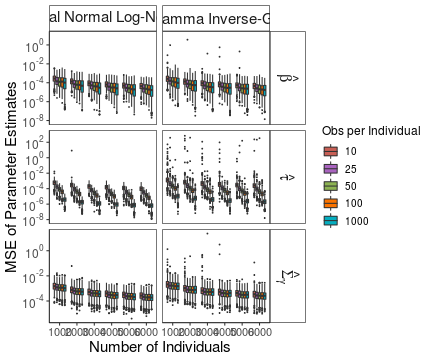

RObject{VecSxp}


In [92]:
@rput msedfR

R"""
library(scales)
library(ggplot2)
library(facetscales)
library(data.table)

msedfR <- data.table(msedfR)

msedfR[parameters == "beta",y_min := 10^-8]
msedfR[parameters == "beta",y_max := 10^1]
msedfR[parameters == "tau",y_min := 10^-8]
msedfR[parameters == "tau",y_max := 10^3]
msedfR[parameters == "Sigma",y_min := 10^-5]
msedfR[parameters == "Sigma",y_max := 10^1]

#msedfR[parameters == "beta",y_min := 10^-8]
#msedfR[parameters == "beta",y_max := 10^-2]
#msedfR[parameters == "tau",y_min := 10^-8]
#msedfR[parameters == "tau",y_max := 10^-2]
#msedfR[parameters == "Sigma",y_min := 10^-5]
#msedfR[parameters == "Sigma",y_max := 10^-2]


msedfR$obssize <- factor(msedfR$obssize, levels = c('10', '25', '50', '100', '1000'))
msedfR$samplesize <- factor(msedfR$samplesize, levels = c('1000', '2000', '3000', '4000', '5000', '6000'))
msedfR$parameters <- factor(msedfR$parameters, levels = c('beta', 'tau', 'Sigma'),
    labels = c(beta = expression(hat(bold(beta))), tau = expression(hat(bold(tau))), 
            Sigma = expression(hat(bold(Sigma))[bold(gamma)])))
msedfR$robust <- factor(msedfR$robust, levels = c('Normal Normal Log-Normal', 'MvT Gamma Inverse Gamma'),
    labels = c(expression(paste("Normal Normal Log-Normal")), expression(paste("MvT Gamma Inverse-Gamma"))))


#mseplot <- ggplot(msedfR[msedfR$mse < 10^0, ], aes(x=samplesize, y=mse, fill=obssize)) + 
mseplot <- ggplot(msedfR[msedfR$mse < 10^3, ], aes(x=samplesize, y=mse, fill=obssize)) + 
  #geom_boxplot(outlier.size = 0.0, outlier.alpha = 0) +
  geom_boxplot(outlier.size = 0.25) +
#    geom_violin() +
    facet_grid(parameters ~ robust, labeller = label_parsed, scales = "free_y") +
  theme(legend.position="right", legend.key = element_blank(), axis.text.x = element_text(angle=0, size=11),
        axis.text.y = element_text(angle=0, size=12), axis.title.x = element_text(size = 15), 
        axis.title.y = element_text(size = 15), legend.title = element_text(size = 12),
        panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
        legend.text=element_text(size=10), panel.background = element_rect(fill = NA, color = "black"),
        #panel.background = element_blank(), #panel.border = element_blank(),
        axis.line = element_line(color = 'black',size=0.3), plot.title = element_text(hjust = 0.5),
        strip.background = element_rect(colour="black", fill="white"), strip.text.y = element_text(size=15, face="bold"),
        strip.text.x = element_text(size=15)) + 
  scale_fill_manual(values = c("#c85f55",
"#a964bf",
"#8db352",
"#fa7300",
"#05aec0")) +
#scale_y_log10(breaks = scales::trans_breaks("log10", function(x) 10^x)) +
#scale_y_log10(breaks = 10^(-8:8), limit=c(10^-8, 10^2)) + 
scale_y_log10(breaks = 10^seq(-10, 10, 2), labels=trans_format("log10", math_format(10^.x))) + #, limit=c(10^-8, 10^2)) +
  labs(x = "Number of Individuals", y = "MSE of Parameter Estimates", fill = "Obs per Individual") +
geom_blank(aes(y = y_max)) + 
geom_blank(aes(y = y_min)) 

"""

In [93]:
R"""
ggsave('result_files/updated_msefacetplot.png', mseplot, width = 12.5, height = 15, units = 'in', dpi = 450)
"""

RObject{NilSxp}
NULL


### Supplementary Tables S.1 and S.2

The following produces coverage tables from Supplementary Materials for the two simulations.

##### Supplementary Table S.2

The following code produces results seen in the Supplementary Table S.2.

In [52]:
using Random, DataFrames, DelimitedFiles, Statistics
import StatsBase: sem
ENV["COLUMNS"]=800

βτcoverage = readdlm("result_files/beta_tau_coverage_5betas_mvt_gamma_invgamma_1000reps_sim.csv", ',')
samplesizes = collect(1000:1000:6000)
ns = [10; 25; 50; 100; 1000]
nsims = 1000

covdf = DataFrame(transpose(βτcoverage))
rename!(covdf, Symbol.([["β$i" for i in 1:p]; ["τ$i" for i in 1:l]]))
covdf[!, :samplesize] = sample_sizes
covdf[!, :obssize] = obs_sizes
covdf = filter(row -> !any(isnan.([row[i] for i in length(row) - 2])), covdf)
first(covdf, 10)

row_stats = [[(mean(col), sem(col)) for col = eachcol(d[!, 1:end-2])] for d = groupby(covdf, [:samplesize; :obssize])]
df = DataFrame(row_stats)
ss_obs = unique("m: " .* sample_sizes .* "  ni: " .* obs_sizes)
rename!(df, Symbol.(ss_obs))
covdfdisplay = DataFrame([[names(df)]; collect.(eachrow(df))], 
    [:people_obs; Symbol.([["β$i" for i in 1:p]; ["τ$i" for i in 1:l]])])
deletecols!(covdfdisplay, p + 2)
covdfdisplay

┌ Warning: `deletecols!(df::DataFrame, inds)` is deprecated, use `select!(df, Not(inds))` instead.
│   caller = top-level scope at In[52]:23
└ @ Core In[52]:23


,people_obs,β1,β2,β3,β4,β5,τ2,τ3,τ4,τ5
,String,Tuple…,Tuple…,Tuple…,Tuple…,Tuple…,Tuple…,Tuple…,Tuple…,Tuple…
1,m: 1000 ni: 10,"(0.946, 0.00715088)","(0.959, 0.00627362)","(0.961, 0.00612507)","(0.953, 0.00669596)","(0.958, 0.00634636)","(0.919, 0.00863212)","(0.937, 0.00768701)","(0.928, 0.0081782)","(0.932, 0.00796489)"
2,m: 1000 ni: 25,"(0.944, 0.0072744)","(0.952, 0.00676326)","(0.947, 0.00708811)","(0.945, 0.00721298)","(0.951, 0.00682976)","(0.937, 0.00768701)","(0.942, 0.00739532)","(0.949, 0.00696042)","(0.938, 0.00762982)"
3,m: 1000 ni: 50,"(0.965, 0.00581453)","(0.954, 0.00662781)","(0.959, 0.00627362)","(0.948, 0.00702462)","(0.953, 0.00669596)","(0.954, 0.00662781)","(0.942, 0.00739532)","(0.948, 0.00702462)","(0.946, 0.00715088)"
4,m: 1000 ni: 100,"(0.959, 0.00627362)","(0.948, 0.00702462)","(0.942, 0.00739532)","(0.949, 0.00696042)","(0.955, 0.00655881)","(0.94, 0.00751375)","(0.946, 0.00715088)","(0.946, 0.00715088)","(0.962, 0.00604918)"
5,m: 1000 ni: 1000,"(0.949, 0.00696042)","(0.945, 0.00721298)","(0.957, 0.00641811)","(0.947, 0.00708811)","(0.943, 0.00733518)","(0.946, 0.00715088)","(0.949, 0.00696042)","(0.944, 0.0072744)","(0.94, 0.00751375)"
6,m: 2000 ni: 10,"(0.9499, 0.00690893)","(0.940882, 0.00746931)","(0.946894, 0.00710192)","(0.9499, 0.00690893)","(0.948898, 0.006974)","(0.937876, 0.00764462)","(0.930862, 0.00803442)","(0.928858, 0.00814125)","(0.941884, 0.00740969)"
7,m: 2000 ni: 25,"(0.951, 0.00682976)","(0.944, 0.0072744)","(0.949, 0.00696042)","(0.947, 0.00708811)","(0.96, 0.00619987)","(0.947, 0.00708811)","(0.935, 0.00779973)","(0.942, 0.00739532)","(0.939, 0.00757208)"
8,m: 2000 ni: 50,"(0.948, 0.00702462)","(0.951, 0.00682976)","(0.936, 0.00774364)","(0.957, 0.00641811)","(0.955, 0.00655881)","(0.948, 0.00702462)","(0.955, 0.00655881)","(0.945, 0.00721298)","(0.946, 0.00715088)"
9,m: 2000 ni: 100,"(0.958, 0.00634636)","(0.949, 0.00696042)","(0.939, 0.00757208)","(0.954, 0.00662781)","(0.951, 0.00682976)","(0.951, 0.00682976)","(0.96, 0.00619987)","(0.958, 0.00634636)","(0.953, 0.00669596)"


In [87]:
using Printf   
println("\\begin{table}[ht]")
println("\\begin{center}")
println("\\begin{adjustbox}{width=\\textwidth}")
println("\\begin{tabular}{lcccccccccc}")
println("\\toprule")
println("\\multicolumn{1}{c}{\\,}&\\multicolumn{5}{c}{\$\\betabf\$}&\\multicolumn{5}{c}{\$\\taubf\$}\\\\\\cmidrule(lr){2-6}\\cmidrule(lr){7-10}")
println(" sample size: obs per & \$\\beta_1\$  & \$\\beta_2\$ & \$\\beta_3\$ & \$\\beta_4\$ & \$\\beta_5\$ & & \$\\tau_2\$ & \$\\tau_3\$ & \$\\tau_4\$ & \$\\tau_5\$ \\\\\\midrule")
m, n = size(covdfdisplay)
for j in 1:m
    print(" $(covdfdisplay[j, 1])")
print(join([" & " * @sprintf("%.3f", covdfdisplay[j, i][1]) * " (" * @sprintf("%.3f", covdfdisplay[j, i][2]) * ") " for i in 2:n]))
    println(" \\\\ ")
end
println("\\bottomrule")
println("\\end{tabular}")
println("\\end{adjustbox}")
println("\\end{center}")
println("\\caption{Empirical coverage rate of 95\\% confidence intervals for the (Multivariate T, Multivariate Gamma, Inverse Gamma) simulations. Listed are the empirical coverage rates with standard errors in the parentheses based on 1000 replicates.}")
println("\\label{table:coverage_table_mvt_gamma}")
println("\\end{table}%")

\begin{table}[ht]
\begin{center}
\begin{adjustbox}{width=\textwidth}
\begin{tabular}{lcccccccccc}
\toprule
\multicolumn{1}{c}{\,}&\multicolumn{5}{c}{$\betabf$}&\multicolumn{5}{c}{$\taubf$}\\\cmidrule(lr){2-6}\cmidrule(lr){7-10}
 sample size: obs per & $\beta_1$  & $\beta_2$ & $\beta_3$ & $\beta_4$ & $\beta_5$ & & $\tau_2$ & $\tau_3$ & $\tau_4$ & $\tau_5$ \\\midrule
 m: 1000  ni: 10 & 0.946 (0.007)  & 0.959 (0.006)  & 0.961 (0.006)  & 0.953 (0.007)  & 0.958 (0.006)  & 0.919 (0.009)  & 0.937 (0.008)  & 0.928 (0.008)  & 0.932 (0.008)  \\ 
 m: 1000  ni: 25 & 0.944 (0.007)  & 0.952 (0.007)  & 0.947 (0.007)  & 0.945 (0.007)  & 0.951 (0.007)  & 0.937 (0.008)  & 0.942 (0.007)  & 0.949 (0.007)  & 0.938 (0.008)  \\ 
 m: 1000  ni: 50 & 0.965 (0.006)  & 0.954 (0.007)  & 0.959 (0.006)  & 0.948 (0.007)  & 0.953 (0.007)  & 0.954 (0.007)  & 0.942 (0.007)  & 0.948 (0.007)  & 0.946 (0.007)  \\ 
 m: 1000  ni: 100 & 0.959 (0.006)  & 0.948 (0.007)  & 0.942 (0.007)  & 0.949 (0.007)  & 0.955 (0.007)  & 0.940

Check number of outliers in most extreme cases

In [189]:
R"""
f2 <- function(x) length(x) / 1000
sapply(layer_data(mseplot, 1)$outliers, f2)
"""

RObject{RealSxp}
  [1] 0.014 0.001 0.000 0.001 0.012 0.008 0.001 0.001 0.001 0.003 0.007 0.005
 [13] 0.001 0.001 0.005 0.007 0.000 0.000 0.001 0.002 0.008 0.001 0.001 0.000
 [25] 0.001 0.007 0.002 0.000 0.001 0.010 0.012 0.006 0.002 0.001 0.012 0.003
 [37] 0.003 0.000 0.001 0.009 0.016 0.003 0.002 0.000 0.009 0.012 0.001 0.000
 [49] 0.000 0.011 0.010 0.006 0.001 0.001 0.019 0.005 0.001 0.002 0.002 0.005
 [61] 0.018 0.015 0.016 0.011 0.021 0.018 0.017 0.018 0.021 0.017 0.018 0.018
 [73] 0.016 0.021 0.019 0.023 0.024 0.015 0.013 0.018 0.035 0.020 0.020 0.020
 [85] 0.023 0.022 0.023 0.012 0.020 0.020 0.040 0.031 0.020 0.028 0.033 0.028
 [97] 0.029 0.021 0.019 0.019 0.031 0.024 0.023 0.020 0.022 0.026 0.016 0.016
[109] 0.021 0.024 0.025 0.020 0.015 0.017 0.031 0.024 0.023 0.031 0.018 0.024
[121] 0.004 0.010 0.011 0.011 0.012 0.010 0.009 0.010 0.010 0.004 0.007 0.013
[133] 0.015 0.012 0.012 0.009 0.010 0.005 0.010 0.007 0.014 0.010 0.009 0.015
[145] 0.009 0.013 0.010 0.018 0.008 0.005 0.021

In [191]:
R"""
sort(sapply(layer_data(mseplot, 1)$outliers, f2))
"""

RObject{RealSxp}
  [1] 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.001 0.001 0.001
 [13] 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001
 [25] 0.001 0.001 0.001 0.002 0.002 0.002 0.002 0.002 0.002 0.003 0.003 0.003
 [37] 0.003 0.004 0.004 0.004 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 [49] 0.006 0.006 0.006 0.006 0.006 0.006 0.006 0.006 0.007 0.007 0.007 0.007
 [61] 0.007 0.007 0.007 0.007 0.007 0.008 0.008 0.008 0.008 0.008 0.008 0.008
 [73] 0.009 0.009 0.009 0.009 0.009 0.009 0.009 0.009 0.009 0.010 0.010 0.010
 [85] 0.010 0.010 0.010 0.010 0.010 0.010 0.010 0.010 0.011 0.011 0.011 0.011
 [97] 0.012 0.012 0.012 0.012 0.012 0.012 0.012 0.012 0.012 0.012 0.013 0.013
[109] 0.013 0.013 0.013 0.014 0.014 0.014 0.015 0.015 0.015 0.015 0.015 0.016
[121] 0.016 0.016 0.016 0.016 0.017 0.017 0.017 0.017 0.018 0.018 0.018 0.018
[133] 0.018 0.018 0.018 0.018 0.018 0.019 0.019 0.019 0.019 0.020 0.020 0.020
[145] 0.020 0.020 0.020 0.020 0.020 0.020 0.021

Maximum number of outliers of any scenario is 4%.

In [188]:
R"""
max(sapply(layer_data(mseplot, 1)$outliers, f2))
"""

RObject{RealSxp}
[1] 0.04


In [192]:
R"""
mean(sapply(layer_data(mseplot, 1)$outliers, f2))
"""

RObject{RealSxp}
[1] 0.01187222


In [193]:
R"""
median(sapply(layer_data(mseplot, 1)$outliers, f2))
"""

RObject{RealSxp}
[1] 0.01
